In [1]:
import sys
# !{sys.executable} -m pip install shap
from glob import glob
import numpy as np
import joblib
import os
import pandas as pd
import json

import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from tqdm.notebook import tqdm
import seaborn as sns
from collections import Counter

# SHAP
import shap

In [2]:
exists=[os.path.basename(i).replace('_A.xyz','') for i in pd.read_csv('/Users/grierjones/qregress/database/processed/intermediate/existing_molsA.csv')['XYZ']]
hypo=[os.path.basename(i).replace('_A.xyz','') for i in pd.read_csv('/Users/grierjones/qregress/database/processed/intermediate/hypothetical_molsA.csv')['XYZ']]

In [3]:
indexing=dict(enumerate(list(enumerate(exists))+list(enumerate(hypo))))

In [4]:
indexing[2000]

(49, 'B-B_50')

In [5]:
pd.read_csv('/Users/grierjones/qregress/database/processed/BSE49.csv')[pd.read_csv('/Users/grierjones/qregress/database/processed/BSE49.csv')['Unnamed: 0']==49]

,Unnamed: 0,RDKit_desc_MaxAbsEStateIndex,RDKit_desc_MaxEStateIndex,RDKit_desc_MinAbsEStateIndex,RDKit_desc_MinEStateIndex,RDKit_desc_qed,RDKit_desc_MolWt,RDKit_desc_HeavyAtomMolWt,RDKit_desc_ExactMolWt,RDKit_desc_NumValenceElectrons,...,RDKit_desc_fr_oxazole,RDKit_desc_fr_oxime,RDKit_desc_fr_piperdine,RDKit_desc_fr_piperzine,RDKit_desc_fr_priamide,RDKit_desc_fr_term_acetylene,RDKit_desc_fr_tetrazole,RDKit_desc_fr_unbrch_alkane,RDKit_desc_fr_urea,BSE
49,49,0.0,0.0,0.0,0.0,0.357530,100.375,60.055,100.313001,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,95.42
2000,49,0.0,0.0,0.0,0.0,0.286471,144.052,109.780,144.228804,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,105.96


In [6]:
# # pixelsx = 150 # Don't make too large 150
# # pixelsy = 150 # 150
# pixelsx = 20 # Don't make too large 150
# pixelsy = 20 # 150
# spread = 0.06
# Max = 2.5 # 2.5
# VariancePersistv1(f'STRUCTURE/{file}.xyz', pixelx=pixelsx, pixely=pixelsy,myspread=spread, myspecs={"maxBD": Max, "minBD":  -0.1}, showplot=False)


In [7]:
len(glob('/Users/grierjones/qregress/database/bse49-main/Geometries/Existing/*xyz'))

5853

In [8]:
trainsize=[ 0.1,0.3, 0.5, 0.7,0.8]

In [9]:


gaussian_kernel = RBF()

models = {
    'ridge': Ridge(),
    'lasso': Lasso(),
    'elastic': ElasticNet(),
    'knn': KNeighborsRegressor(),
    'rfr': RandomForestRegressor(),
    'grad': GradientBoostingRegressor(),
    'svr': SVR(),
    'krr': KernelRidge(),
    'gpr': GaussianProcessRegressor()
}

param_grid = {
    'ridge': {
        'alpha': [0.001, 0.01, 0.1, 1, 10, 50, 100, 1000]
    },
    'knn': {
        'n_neighbors': range(1, 10),
        'weights': ['uniform', 'distance']
    },
    'rfr': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5, 10]
    },
    'grad': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.1, 0.01, 0.001],
        'max_depth': [3, 5, 7]
    },
    'svr': {
        'kernel': ['linear', 'rbf'],
        'C': [0.1, 1, 10],
        'epsilon': [0.1, 0.01, 0.001]
    },
    'krr': {
        'kernel': ['linear', 'poly', 'rbf'],
        'alpha': [0.001, 0.01, 0.1, 1],
        'gamma': [1, 0.1, 0.01, 0.001]
    },
    'gpr': {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
        'kernel': [gaussian_kernel]
    },
    'lasso': {
        'alpha': [0.001, 0.01, 0.1, 1],
        'max_iter': [1000, 2000, 3000]
    },
    'elastic': {
        'alpha': [0.001, 0.01, 0.1, 1],
        'l1_ratio': [0.2, 0.5, 0.8],
        'max_iter': [1000, 2000, 3000]
    }
}


In [10]:
def gridsearch(model,X_tr, y_tr,X_tst,y_tst):
    """
    Perform GridSearchCV for a given model

    parameters
    ----------
    model: str
        Name of model

    X_tr: np.array
        X training

    y_tr: np.array
        Y Training

    X_tst: np.array
        X test

    y_tst: np.array
        y test

    Returns
    -------
    scores: dict
        scored models
    """
    print(X_tr.shape, y_tr.shape,X_tst.shape,y_tst.shape)
    st = time.time()
    # Grab model and model parameters to perform gridsearchcv
    current_model = models[model]
    current_param_grid = param_grid[model]

    grid_search = GridSearchCV(current_model, current_param_grid, cv=5,n_jobs=-1)

    print(f'Now fitting {model}... ')

    grid_search.fit(X_tr, y_tr)

    best_model = grid_search.best_estimator_

    print(f'Completed fitting {model} in {time.time() - st} seconds. ')

    # Take the best model and evaluate using known metrics
    model=best_model
    scores = {}
    st = time.time()
    print('Now scoring model... ')
    y_tr_pred = model.predict(X_tr)
    y_tst_pred = model.predict(X_tst)

    plt.scatter(y_tr,y_tr_pred)
    plt.scatter(y_tst,y_tst_pred)
    plt.scatter(y_tr, y_tr)
    plt.scatter(y_tst,y_tst)
    plt.show()
            
    scores['MSE_train'] = mean_squared_error(y_tr, y_tr_pred),
    scores['R2_train'] = r2_score(y_tr, y_tr_pred)
    scores['MAE_train'] = mean_absolute_error(y_tr, y_tr_pred)
    scores['MSE_test'] = mean_squared_error(y_tst, y_tst_pred)
    scores['R2_test'] = r2_score(y_tst, y_tst_pred)
    scores['MAE_test'] = mean_absolute_error(y_tst, y_tst_pred)

    return scores, best_model



(3515, 151) (3515,) (879, 151) (879,)
Now fitting rfr... 


/Users/grierjones/miniconda3/envs/qchem/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.0 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Completed fitting rfr in 59.97976112365723 seconds. 
Now scoring model... 


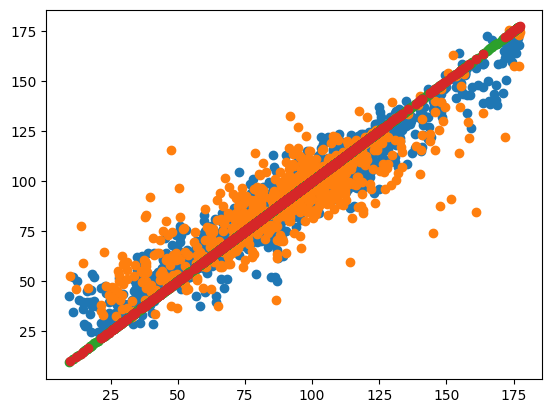

In [11]:
with open("./BSE/BSE49_full_test.bin",'rb') as f:
    testdata=joblib.load(f)
    
with open("./BSE/BSE49_full_train.bin",'rb') as f:
    traindata=joblib.load(f)

with open("./BSE/BSE49_full_scaler.bin",'rb') as f:
    scaler = joblib.load(f)
X_train=traindata['X']
y_train=scaler.inverse_transform(traindata['y'].reshape(-1,1)).flatten()

X_test=testdata['X']
y_test=scaler.inverse_transform(testdata['y'].reshape(-1,1)).flatten()
ALL_scores, ALL_best_model = gridsearch("rfr",X_train, y_train,X_test,y_test)


In [12]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [13]:
def remove_colinearity(df, threshold):
    correlation = df.corr().abs()
    upper_matrix = correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(bool))
    drop_cols = [column for column in upper_matrix.columns if any(upper_matrix[column] > threshold)]
    print(f'Dropping {drop_cols} due to correlation greater than {threshold}... \n')
    df = df.drop(drop_cols, axis=1, inplace=False)
    return df

In [14]:
dropped=remove_colinearity(pd.DataFrame(X_train), 0.9)

Dropping [6, 7, 8, 10, 11, 47, 51, 55, 56, 61, 65, 68, 86, 87, 88, 94, 95, 96, 103] due to correlation greater than 0.9... 



In [15]:
with open("/Users/grierjones/qregress/database/BSE49_Hypothetical_train.bin",'rb') as f:
    print(joblib.load(f)['X'].shape)

(1954, 133)


In [16]:
with open("BSE/BSE49_full_train.bin",'rb') as f:
    print(joblib.load(f)['X'].shape)

(3515, 151)


In [17]:
X_all=pd.read_csv('/Users/grierjones/qregress/database/processed/intermediate/BSE49_existing.csv',index_col=0).drop(columns='BSE')

PermutationExplainer explainer: 1952it [07:14,  4.39it/s]                                                                                                                                                         


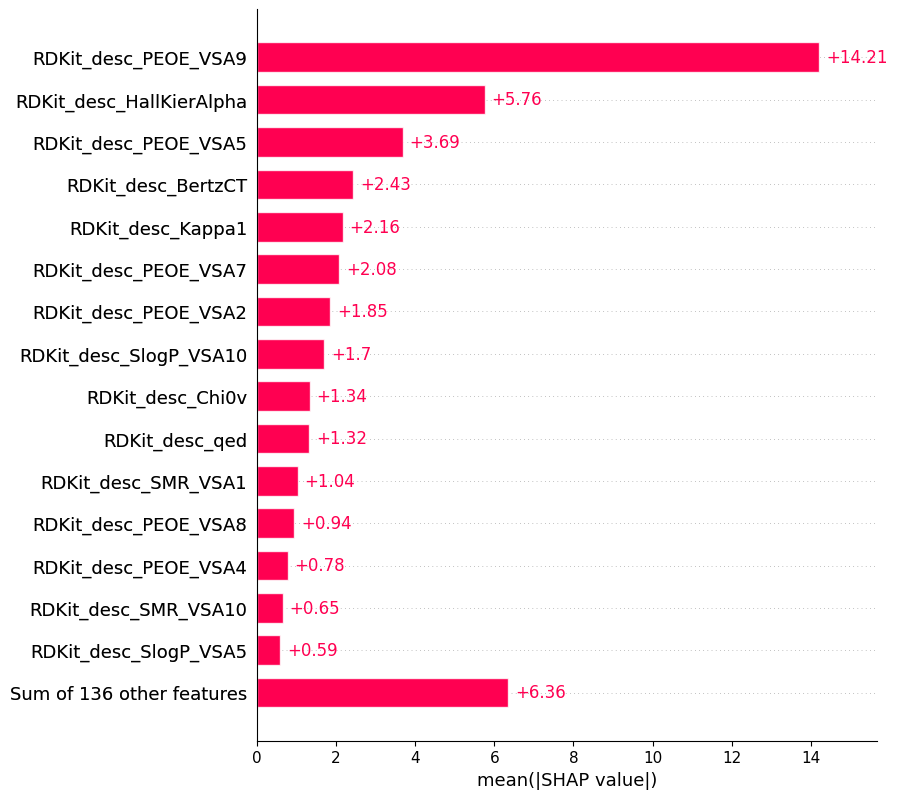

In [18]:
explainer = shap.Explainer(ALL_best_model.predict, X_test,n_jobs=-1)
shap_values = explainer(X_all)
shap.plots.bar(shap_values,max_display=16)


In [19]:
ALL_best_model.score(X_train,y_train),ALL_best_model.score(X_test,y_test)

(0.9426055340736211, 0.7791606252536641)

In [20]:
SHAP_df=pd.DataFrame(np.abs(shap_values.values).mean(0),index=X_all.columns,columns=['mean(|SHAP|)'])
best_16=np.argsort(SHAP_df.values.flatten())[-16:]
best_5=np.argsort(SHAP_df.values.flatten())[-5:]

(3515, 16) (3515,) (879, 16) (879,)
Now fitting rfr... 
Completed fitting rfr in 20.43912100791931 seconds. 
Now scoring model... 


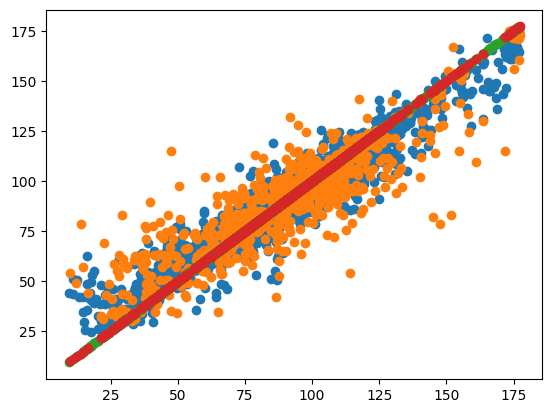

{'MSE_train': (48.023298083366825,), 'R2_train': 0.934248764819639, 'MAE_train': 4.433881819530086, 'MSE_test': 205.76910847966155, 'R2_test': 0.7586465691959847, 'MAE_test': 9.484074968057913}


In [22]:
SHAP16_scores, SHAP16_best_model = gridsearch("rfr",X_train[:,best_16], y_train,X_test[:,best_16],y_test)
print(SHAP16_scores)

(3515, 5) (3515,) (879, 5) (879,)
Now fitting rfr... 
Completed fitting rfr in 8.462560892105103 seconds. 
Now scoring model... 


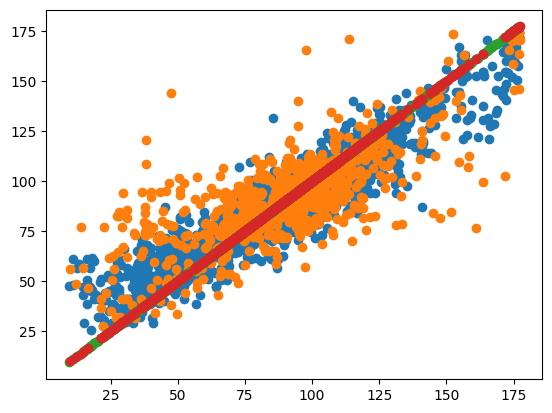

{'MSE_train': (83.92127889480953,), 'R2_train': 0.8850989422744279, 'MAE_train': 6.088285159433418, 'MSE_test': 351.14087583970695, 'R2_test': 0.5881351884857065, 'MAE_test': 12.422937928644872}


In [23]:
SHAP5_scores, SHAP5_best_model = gridsearch("rfr",X_train[:,best_5], y_train,X_test[:,best_5],y_test)
print(SHAP5_scores)

/Users/grierjones/miniconda3/envs/qchem/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.0 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


(3515, 5) (3515,) (879, 5) (879,)
Now fitting rfr... 
Completed fitting rfr in 15.08850884437561 seconds. 
Now scoring model... 


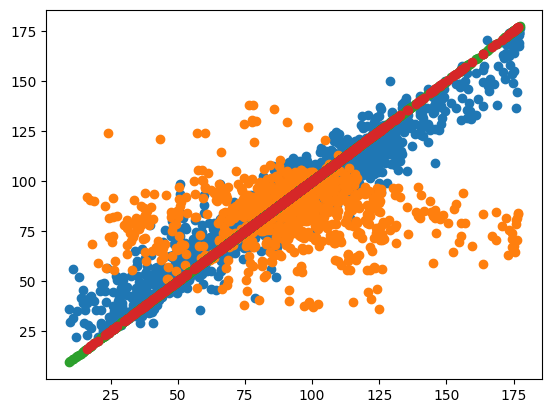

{'MSE_train': (54.39976806835746,), 'R2_train': 0.9270817390902427, 'MAE_train': 4.793606319272003, 'MSE_test': 1016.4052868464022, 'R2_test': -0.28639861439503767, 'MAE_test': 22.851873766975974}


In [24]:
with open("/Users/grierjones/qregress/database/processed/5feats/BSE49_5feats_test.bin",'rb') as f:
    testdata=joblib.load(f)
    
with open("/Users/grierjones/qregress/database/processed/5feats/BSE49_5feats_train.bin",'rb') as f:
    traindata=joblib.load(f)

with open("/Users/grierjones/qregress/database/processed/5feats/BSE49_5feats_scaler.bin",'rb') as f:
    scaler = joblib.load(f)
X_train=traindata['X']
y_train=scaler.inverse_transform(traindata['y'].reshape(-1,1)).flatten()

X_test=testdata['X']
y_test=scaler.inverse_transform(testdata['y'].reshape(-1,1)).flatten()
BSE49_5featsscores, BSE49_5featsbest_model = gridsearch("rfr",X_train, y_train,X_test,y_test)
print(BSE49_5featsscores)

(3515, 16) (3515,) (879, 16) (879,)
Now fitting rfr... 


/Users/grierjones/miniconda3/envs/qchem/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.0 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Completed fitting rfr in 47.98333501815796 seconds. 
Now scoring model... 


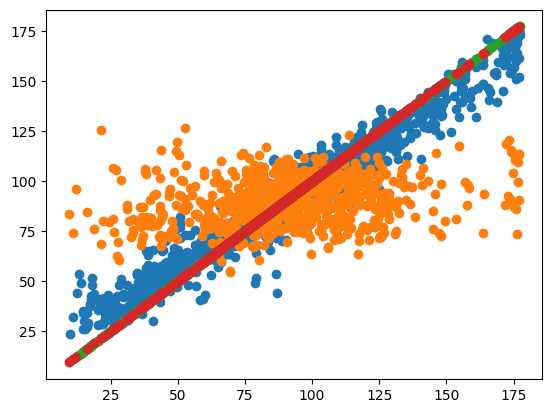

{'MSE_train': (40.048005305753534,), 'R2_train': 0.9460708174821053, 'MAE_train': 4.142503698281804, 'MSE_test': 779.8021495551523, 'R2_test': 0.027859818207117693, 'MAE_test': 20.541977471929535}


In [25]:
with open("/Users/grierjones/qregress/database/processed/16feats/0.8/BSE49_16feats_test.bin",'rb') as f:
    testdata=joblib.load(f)
    
with open("/Users/grierjones/qregress/database/processed/16feats/0.8/BSE49_16feats_train.bin",'rb') as f:
    traindata=joblib.load(f)

with open("/Users/grierjones/qregress/database/processed/16feats/0.8/BSE49_16feats_scaler.bin",'rb') as f:
    scaler = joblib.load(f)
X_train=traindata['X']
y_train=scaler.inverse_transform(traindata['y'].reshape(-1,1)).flatten()

X_test=testdata['X']
y_test=scaler.inverse_transform(testdata['y'].reshape(-1,1)).flatten()
BSE49_16scores, BSE49_16best_model = gridsearch("rfr",X_train, y_train,X_test,y_test)
print(BSE49_16scores)

In [40]:
concatscores=pd.concat([
    pd.DataFrame.from_dict(ALL_scores).rename(index={0:'ALL'}),
    pd.DataFrame.from_dict(BSE49_16scores).rename(index={0:'orig16'}),
    pd.DataFrame.from_dict(BSE49_5featsscores).rename(index={0:'orig5'}),
    pd.DataFrame.from_dict(SHAP16_scores).rename(index={0:'SHAP16'}),
    pd.DataFrame.from_dict(SHAP5_scores).rename(index={0:'SHAP5'})
    
])


In [44]:
# concatscores.to_excel("compareSHAP.xlsx")

In [53]:
R2df=concatscores[['R2_train','R2_test']].reset_index().melt(id_vars='index').rename(columns={'index':'Features','variable':'Metric'})
MAEdf=concatscores[['MAE_train','MAE_test']].reset_index().melt(id_vars='index').rename(columns={'index':'Features','variable':'Metric'})


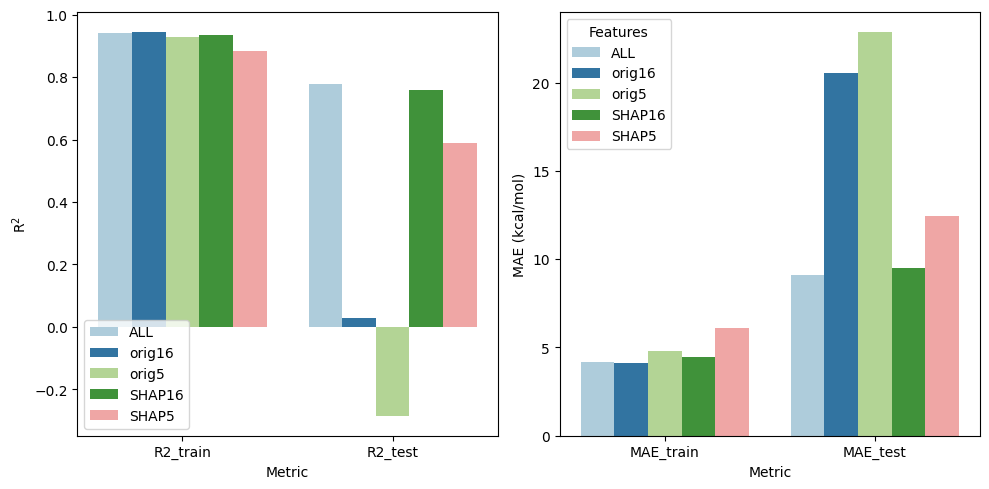

In [74]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1=sns.barplot(R2df,x='Metric',y='value',hue='Features',ax=ax1,palette=sns.color_palette('Paired',5))
ax1.set_ylabel("R$^{2}$")
ax1.legend(loc=3)
ax2=sns.barplot(MAEdf,x='Metric',y='value',hue='Features',ax=ax2,palette=sns.color_palette('Paired',5))
ax2.set_ylabel('MAE (kcal/mol)')
plt.tight_layout()
plt.savefig('compareSHAPmetrics.png',dpi=300,bbox_inches='tight')
plt.show()

In [76]:
concatscores

,MSE_train,R2_train,MAE_train,MSE_test,R2_test,MAE_test
ALL,41.919692,0.942606,4.154944,188.279575,0.779161,9.078057
orig16,40.048005,0.946071,4.142504,779.802150,0.027860,20.541977
orig5,54.399768,0.927082,4.793606,1016.405287,-0.286399,22.851874
SHAP16,48.023298,0.934249,4.433882,205.769108,0.758647,9.484075
SHAP5,83.921279,0.885099,6.088285,351.140876,0.588135,12.422938
